# Study energy resolution with Kr data

<i>
This notebook takes a kDST file and a correction file,
applies all corrections (including time) and studies
the energy resolution.
</i>

### Notebook configuration

In [1]:
run_number          = 4841
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
dst_filename        = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
plots_output_folder = f"plots/{run_number}/"

XY_pitch            = 5.0

Zrange              =     0, 600
XYrange             =  -200, 200
Rrange              =     0, max(XYrange)
Phirange            = -3.14, 3.14

Erange              =  33.5, 49.5
Qrange              =   200, 1500
QErange             =     0, Qrange[1] / Erange[1]

S1Erange            =     0, 40
S1Wrange            =     0, 500
S1Hrange            =     0, 10

S2Erange            =     0, 18e3
S2Wrange            =     0, 50
S2Hrange            =     0, 10e3
NSirange            =     0, 80

Zrange_DV           =   500, 600
Zrange_LT           =    50, 520
Zrange_XY           =     0, 520

XYnbins             =  50
Znbins              = 100
Rnbins              = 100
Phinbins            = 100
Enbins              = 200
Qnbins              = 200

S1Enbins            = 40
S1Wnbins            = 20
S1Hnbins            = 50

S2Enbins            = 100
S2Wnbins            = 50
S2Hnbins            = 80
NSinbins            = 80

DVnbins             = 50

R_fiducial          = 150
Z_fiducial          = 150

# Plotting style
default_cmap        = "jet"
figure_size         = 16, 12
font_size           = 20
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

save_plots          = True
with_titles         = False
plots_format        = "pdf"

### Imports

In [2]:
import os
import time
import collections
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db        as DB
import invisible_cities.core    .core_functions as coref
import invisible_cities.core    .fit_functions  as fitf
import invisible_cities.reco    .corrections    as corrf
import invisible_cities.reco    .dst_functions  as dstf

from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import hist2d
from invisible_cities.icaro. hst_functions import pdf
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import gausstext
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer
from invisible_cities.icaro. hst_functions import measurement_string

from icaro.core.fit_functions import conditional_labels

Running on  Thu Feb  1 13:22:34 2018


### Initialization

In [3]:
save   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None
labels = conditional_labels(with_titles)

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] = figure_size
plt.rcParams[  "font.size"            ] =   font_size
plt.rcParams["figure.max_open_warning"] = 1000

In [5]:
Zbins     = np.linspace(*  Zrange   ,   Znbins + 1)
Ebins     = np.linspace(*  Erange   ,   Enbins + 1)
Qbins     = np.linspace(*  Qrange   ,   Qnbins + 1)

S1Ebins   = np.linspace(*S1Erange   , S1Enbins + 1)
S1Wbins   = np.linspace(*S1Wrange   , S1Wnbins + 1)
S1Hbins   = np.linspace(*S1Hrange   , S1Hnbins + 1)

S2Ebins   = np.linspace(*S2Erange   , S2Enbins + 1)
S2Wbins   = np.linspace(*S2Wrange   , S2Wnbins + 1)
S2Hbins   = np.linspace(*S2Hrange   , S2Hnbins + 1)
NSibins   = np.linspace(*NSirange   , NSinbins + 1)

XYbins    = np.linspace(* XYrange   ,  XYnbins + 1)
Rbins     = np.linspace(*  Rrange   ,   Rnbins + 1)
Phibins   = np.linspace(*Phirange   , Phinbins + 1)
DVbins    = np.linspace(*  Zrange_DV,  DVnbins + 1)

dst_filename        = os.path.expandvars(       dst_filename)
correction_filename = os.path.expandvars(correction_filename)

### Read data

In [6]:
dst = dstf.load_dst(dst_filename, "DST", "Events")
dst = dst[dst.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(dst))
dst.head()

771898


,index,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,6,8,1.510471e+09,0,1,200.0,3.353130,16.994588,823725.0,14.7000,...,1002500.0,41,178.775,178.775,-180.623891,-61.067526,190.667860,-2.815565,18.316797,15.352102
1,12,21,1.510471e+09,0,1,125.0,1.271123,5.763685,883425.0,6.3500,...,1002500.0,36,119.075,119.075,-168.270263,23.257575,169.869939,3.004247,11.466820,13.968665
2,14,27,1.510471e+09,0,1,150.0,1.976865,8.930014,859950.0,6.8375,...,1003500.0,36,143.550,143.550,5.004905,-31.789076,32.180653,-1.414637,22.182517,29.385406
3,17,29,1.510471e+09,0,1,275.0,3.722116,22.847745,613025.0,10.3750,...,1004500.0,35,391.475,391.475,-30.362521,-136.884955,140.211888,-1.789073,14.704709,36.006950
4,18,32,1.510471e+09,0,1,150.0,2.090557,10.226970,449425.0,11.4625,...,1003500.0,28,554.075,554.075,117.304421,41.295697,124.361014,0.338490,23.385198,15.873189


In [7]:
ELT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Lifetime")

QLT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "QLifetime")

EGEO_correction = dstf.load_xy_corrections(correction_filename,
                                           group         =  "XYcorrections",
                                           node          = f"GeometryE_{XY_pitch:.1f}mm",
                                           norm_strategy =  "index",
                                           norm_opts     = {"index": (40, 40)})

QGEO_correction = dstf.load_xy_corrections(correction_filename,
                                           group         =  "XYcorrections",
                                           node          = f"GeometryQ_{XY_pitch:.1f}mm",
                                           norm_strategy =  "index",
                                           norm_opts     = {"index": (40, 40)})

In [8]:
evt = dst.event.values
T   =(dst.time .values -
      dst.time .values.min()) / 60
S2n = dst.nS2  .values

S1e = dst.S1e.values
S1w = dst.S1w.values
S1h = dst.S1h.values
S1t = dst.S1t.values

S2e = dst.S2e.values
S2w = dst.S2w.values
S2h = dst.S2h.values
S2t = dst.S2t.values
S2q = dst.S2q.values

X   = dst.X    .values
Y   = dst.Y    .values
Z   = dst.DT   .values
R   = dst.R    .values
Phi = dst.Phi  .values
Nsi = dst.Nsipm.values

E   = S2e * ELT_correction(Z, X, Y).value * EGEO_correction(X, Y).value
Q   = S2q * QLT_correction(Z, X, Y).value * QGEO_correction(X, Y).value

[ 14821.88665322  -1515.8832717 ]


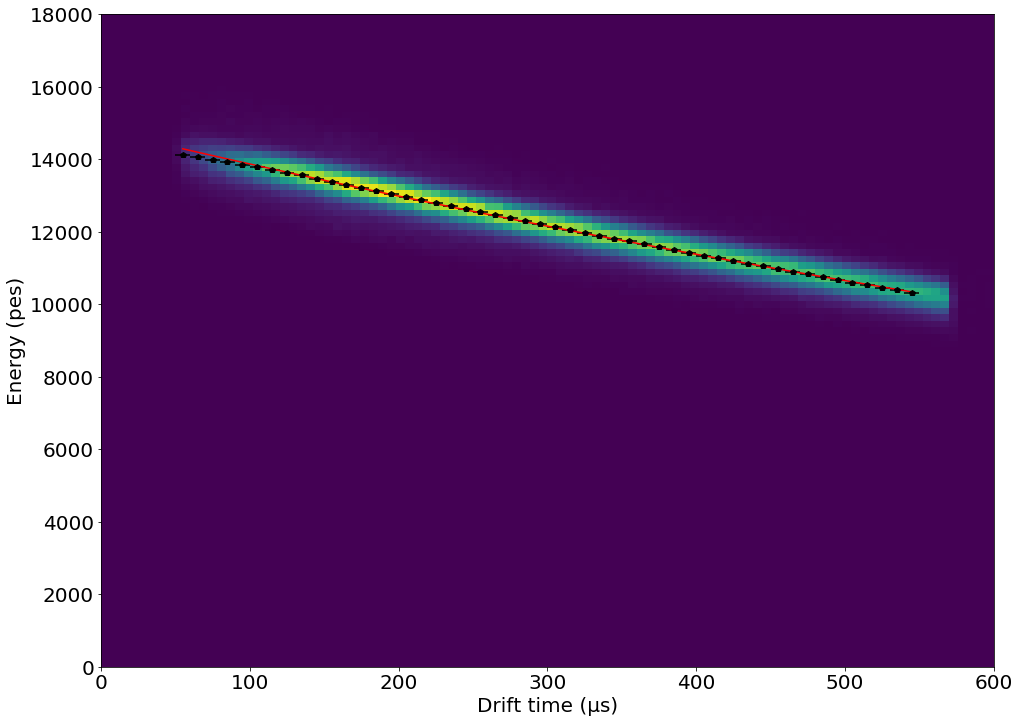

In [9]:
e = S2e * EGEO_correction(X, Y).value
hist2d(Z, e, (Zbins, S2Ebins))

z, e, ue = fitf.profileX(Z, e, 50, (50, 550))
plt.errorbar(z, e, ue, np.diff(z)[0]/2, "kp")

f = fitf.fit(fitf.expo, z, e, (e[0], -1e3), sigma=ue)
plt.plot(z, f.fn(z), "r-")

print(f.values)

E = S2e * fitf.expo(Z, 1, -f.values[1]) * EGEO_correction(X, Y).value
labels("Drift time (µs)", "Energy (pes)")

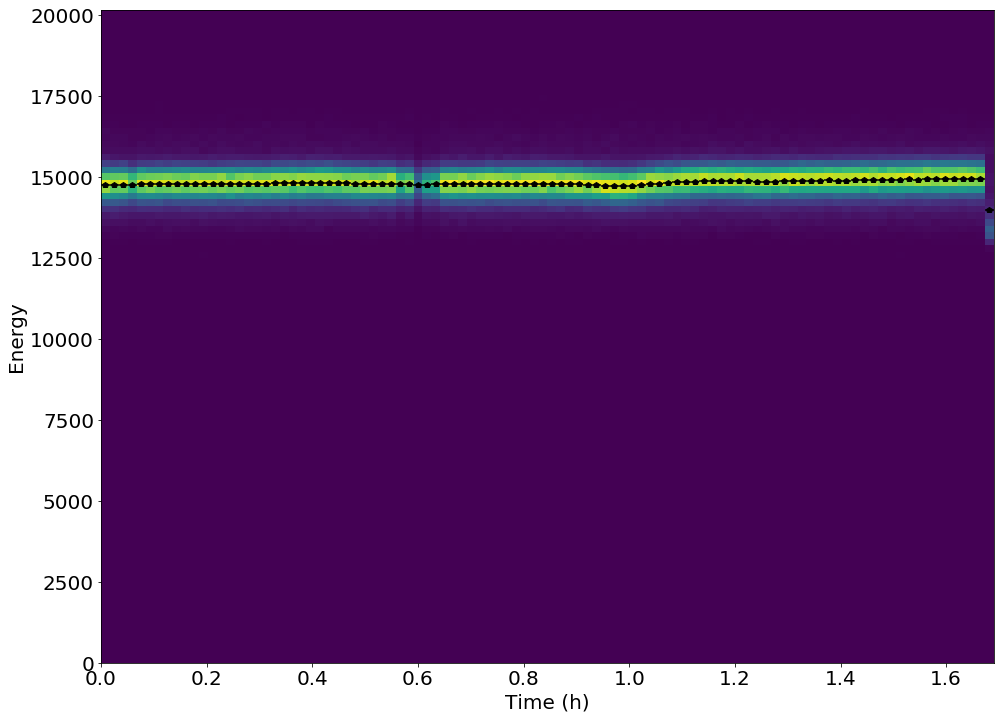

In [10]:
hist2d(T / 3600, E, 100)

t, e, eu = fitf.profileX(T / 3600, E, 100)
plt.errorbar(t, e, eu, np.diff(t)[0]/2, "kp")

labels("Time (h)", "Energy")

In [11]:
t, e, eu = fitf.profileX(T, E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": 41.5})

t, q, qu = fitf.profileX(T, Q, 100)
QT_correction = corrf.Correction((t,), q, qu,
                                 norm_strategy =  "max")

E = E * ET_correction(T).value
Q = Q * QT_correction(T).value

##### Input maps

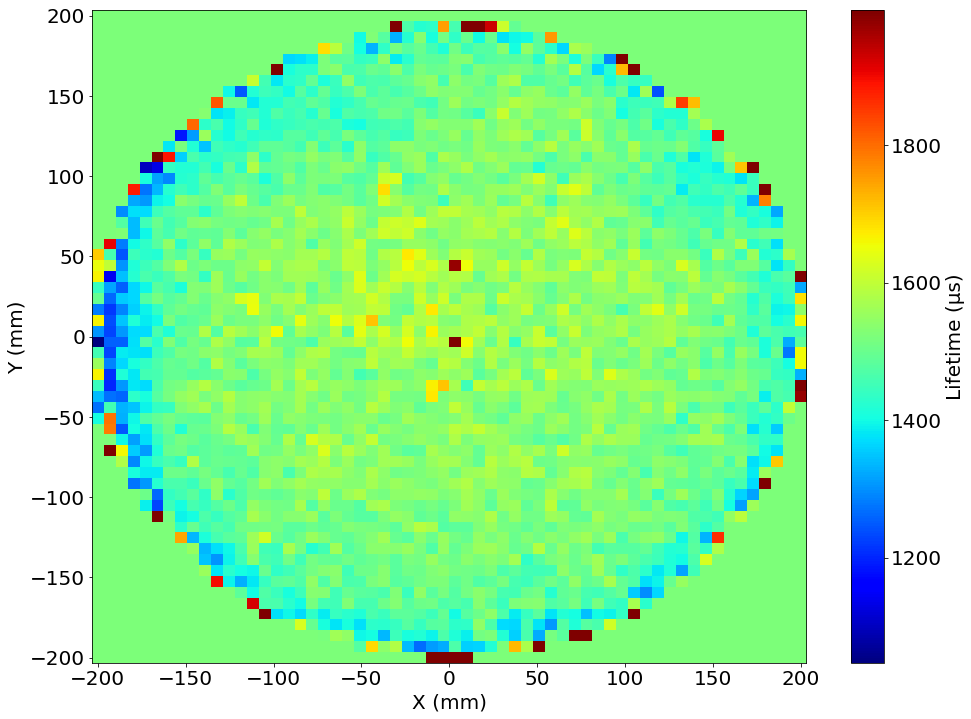

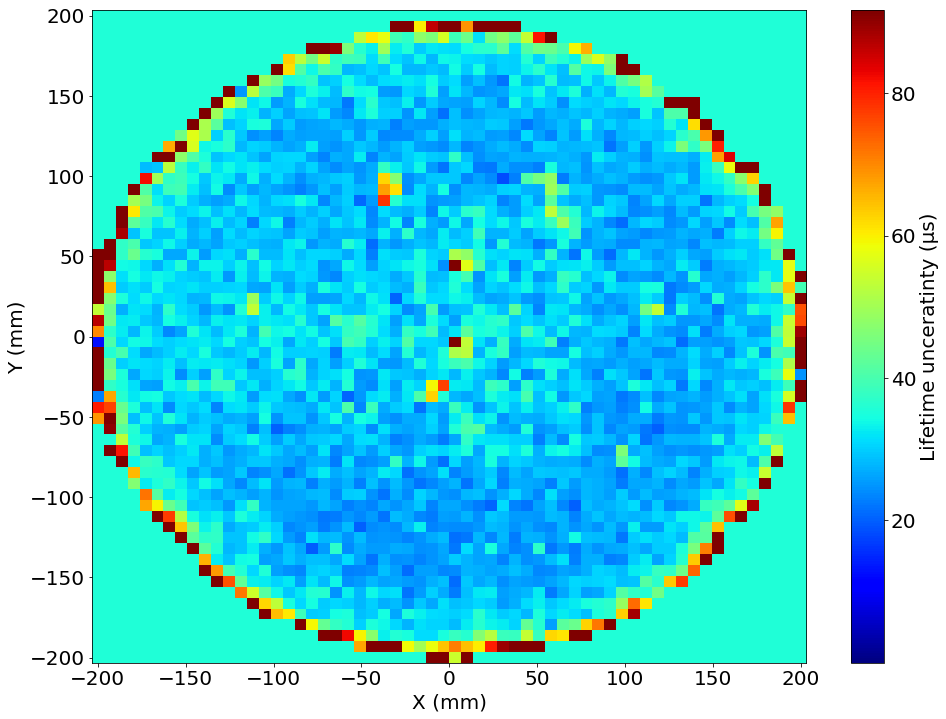

In [12]:
LTmap = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Lifetime")

x   = np.unique(LTmap.x.values)
y   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(x.size, y.size)
LTu = LTmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, LT,
                        vmin = np.mean(LT) - 2.5 * np.std(LT),
                        vmax = np.mean(LT) + 2.5 * np.std(LT),
                        cmap = default_cmap)
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime map")
save("Lifetime_map")

*_, cb = display_matrix(x, y, LTu,
                        vmin = 1e-3,
                        vmax = np.mean(LTu) + np.std(LTu),
                        cmap = default_cmap)

cb.set_label("Lifetime unceratinty (µs)")
labels("X (mm)", "Y (mm)", "Lifetime uncertainty map")
save("Lifetime_uncertainty_map")

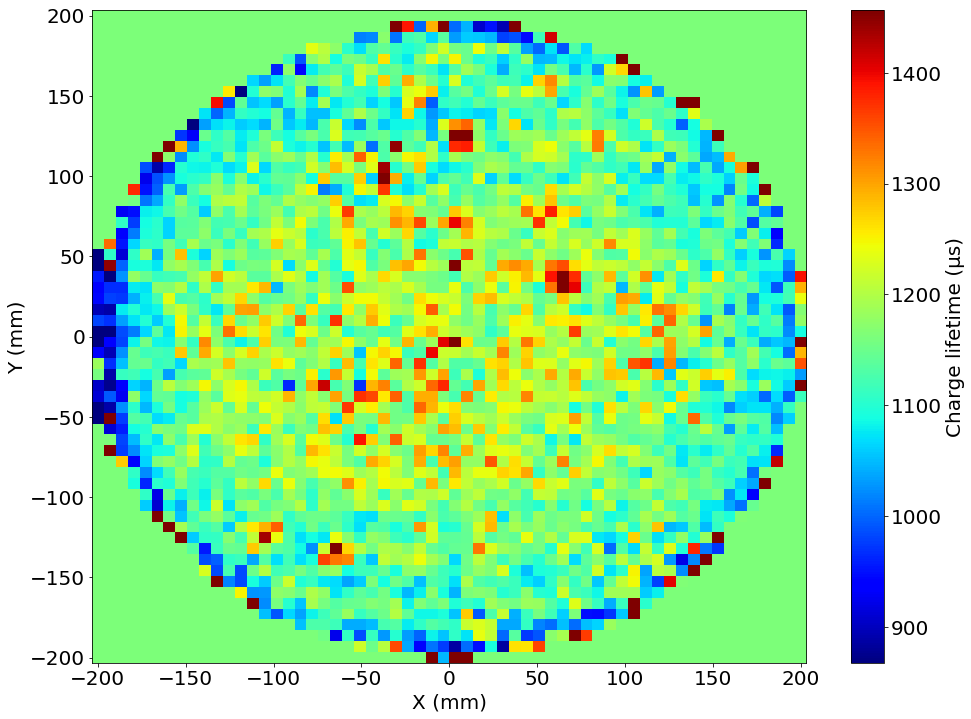

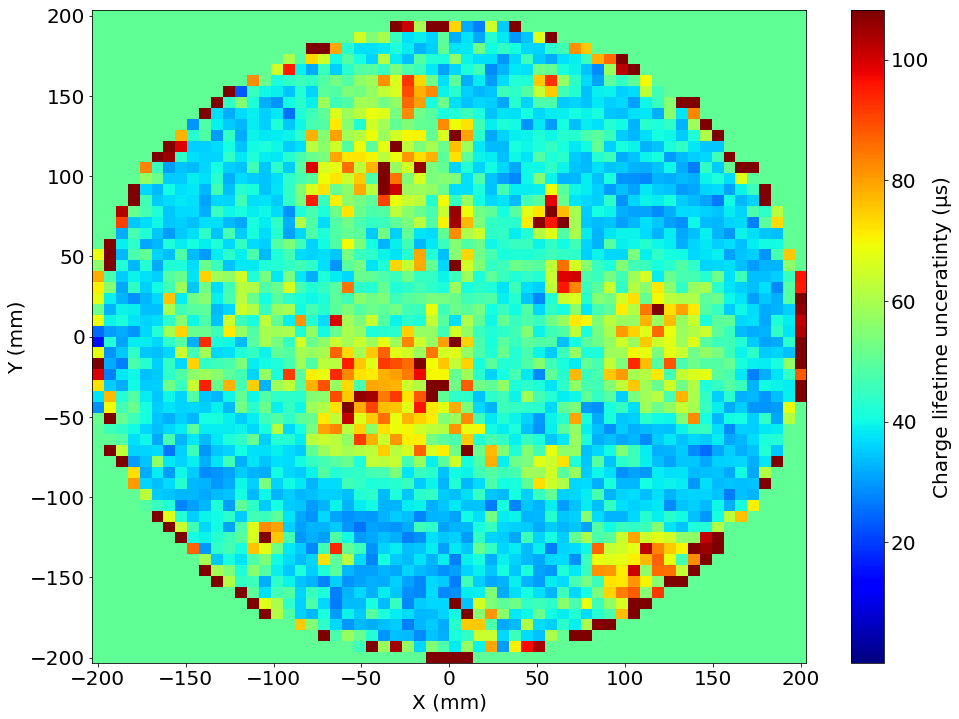

In [13]:
LTmap = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "QLifetime")

x   = np.unique(LTmap.x.values)
y   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(x.size, y.size)
LTu = LTmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, LT,
                        vmin = np.mean(LT) - 2.5 * np.std(LT),
                        vmax = np.mean(LT) + 2.5 * np.std(LT),
                        cmap = default_cmap)
cb.set_label("Charge lifetime (µs)")
labels("X (mm)", "Y (mm)", "Charge lifetime map")
save("Charge_lifetime_map")

*_, cb = display_matrix(x, y, LTu,
                        vmin = 1e-3,
                        vmax = np.mean(LTu) + np.std(LTu),
                        cmap = default_cmap)

cb.set_label("Charge lifetime unceratinty (µs)")
labels("X (mm)", "Y (mm)", "Charge lifetime uncertainty map")
save("Charge_lifetime_uncertainty_map")

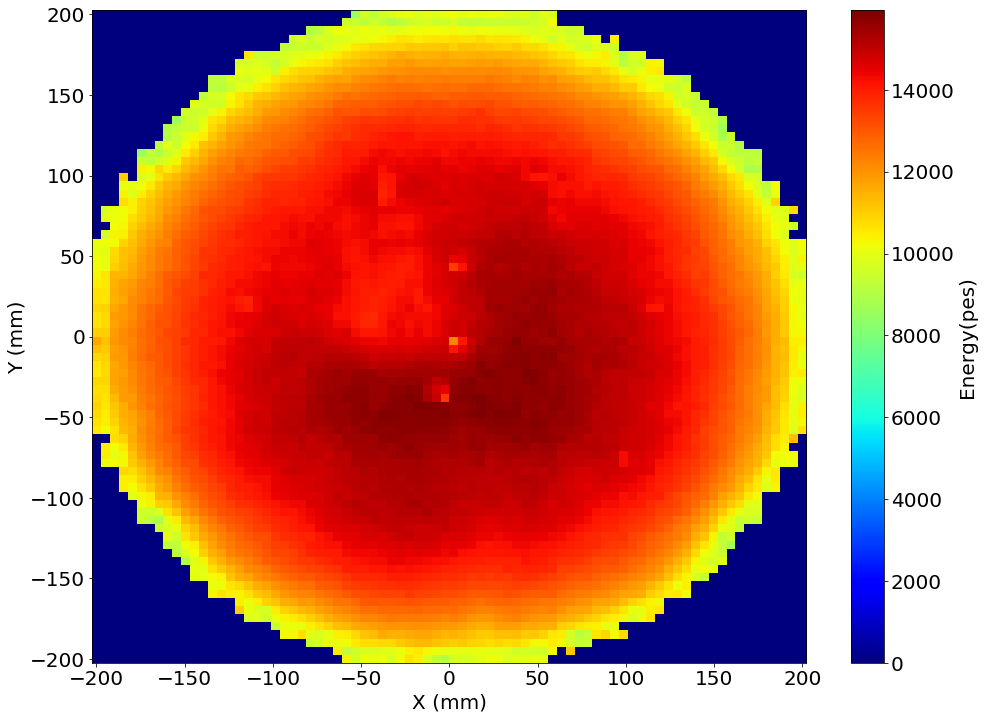

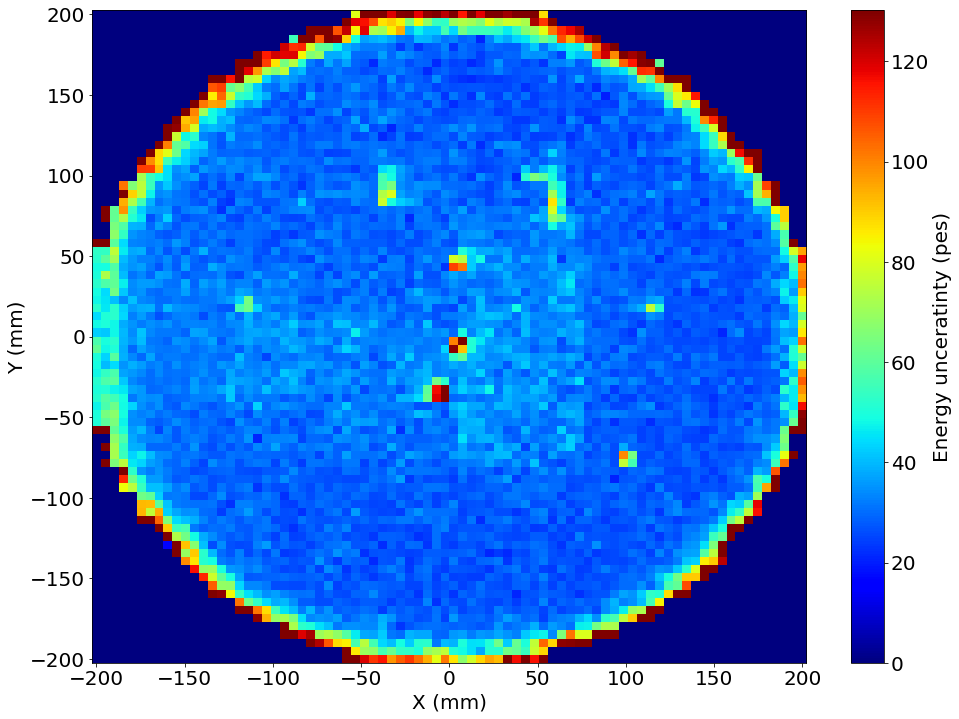

In [14]:
GEOmap = dstf.load_dst(correction_filename,
                       group = "XYcorrections",
                       node  = f"GeometryE_{XY_pitch:.1f}mm")

x  = np.unique(GEOmap.x.values)
y  = np.unique(GEOmap.y.values)
f  = GEOmap.factor     .values.reshape(x.size, y.size)
fu = GEOmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, f,
                        cmap = default_cmap)
cb.set_label("Energy(pes)")
labels("X (mm)", "Y (mm)", "Geometry map")
save("Energy_map")

*_, cb = display_matrix(x, y, fu,
                        vmax = np.mean(fu) + 3 * np.std(fu),
                        cmap = default_cmap)
cb.set_label("Energy unceratinty (pes)")
labels("X (mm)", "Y (mm)", "Geometry uncertainty map")
save("Energy_uncertainty_map")

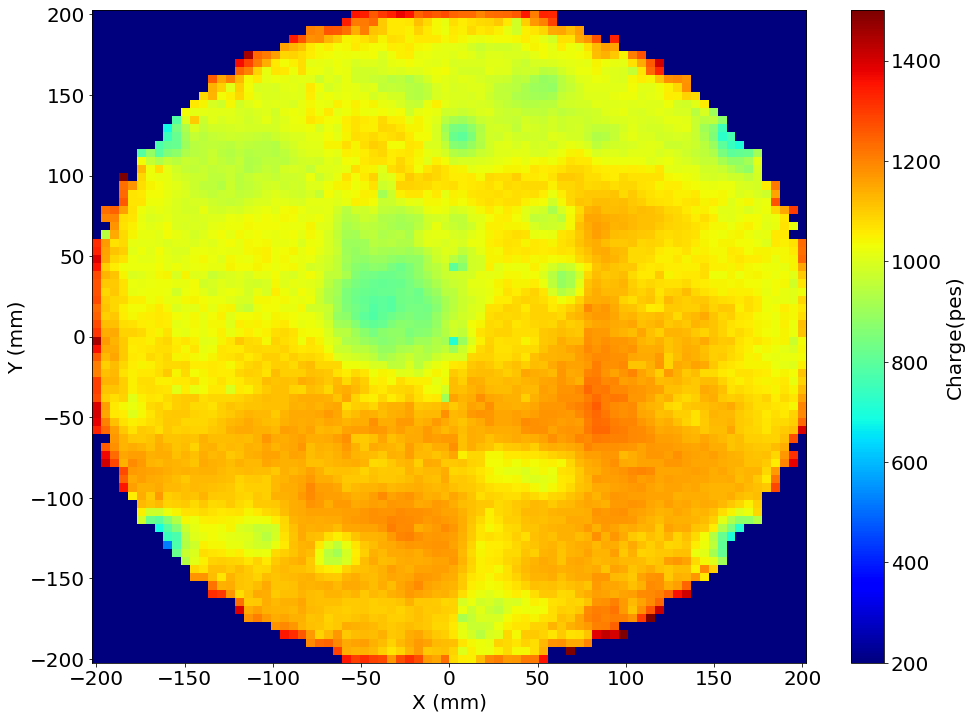

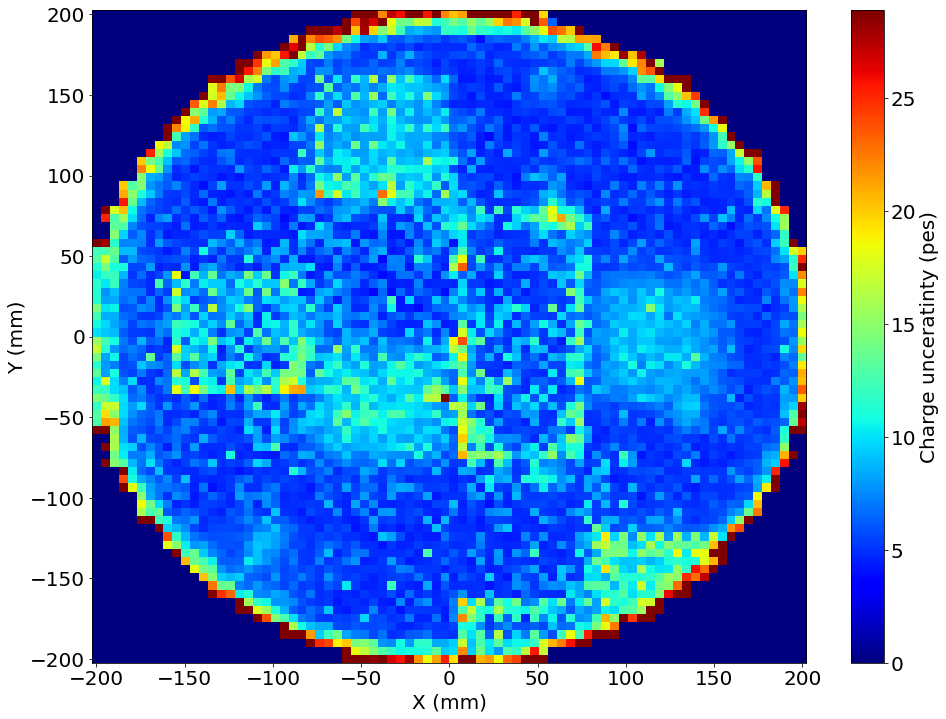

In [15]:
GEOmap = dstf.load_dst(correction_filename,
                       group = "XYcorrections",
                       node  = f"GeometryQ_{XY_pitch:.1f}mm")

x  = np.unique(GEOmap.x.values)
y  = np.unique(GEOmap.y.values)
f  = GEOmap.factor     .values.reshape(x.size, y.size)
fu = GEOmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, f,
                        vmin = Qrange[0],
                        vmax = Qrange[1],
                        cmap = default_cmap)
cb.set_label("Charge(pes)")
labels("X (mm)", "Y (mm)", "Charge map")
save("Charge_map")

*_, cb = display_matrix(x, y, fu,
                        vmax = np.mean(fu) + 3 * np.std(fu),
                        cmap = default_cmap)
cb.set_label("Charge unceratinty (pes)")
labels("X (mm)", "Y (mm)", "Charge uncertainty map")
save("Charge_uncertainty_map")

In [27]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

empty = lambda x, *args: 0

def measure_resolution(E, bkg=fitf.gauss, n_sigma=2):
    y, x  = np.histogram(E, Ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])
    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    bkg_seed = (Npeak*2, Epeak, Speak*50) if bkg is fitf.gauss else (1, 1, 1)
    sig_seed  = Npeak, Epeak, Speak

    seed = (*sig_seed, *bkg_seed)
    fit_range = (Epeak - n_sigma * Speak,
                 Epeak + n_sigma * Speak)
    f    = fitf.fit(fun, x, y, seed,
                    fit_range = fit_range,
                    sigma     = yu,
                    maxfev    = 10000)

    if bkg is not empty:
        assert not np.any(np.isclose(f.values, seed)), f.values

    R   = resolution(f.values, f.errors, 41.5)
    sel = coref.in_range(x, *fit_range)
    ry  = (f.fn(x) - y) / yu
    return reso_fit_data(xy_data(x, y, xu, yu),
                         xy_data(x[sel], ry[sel], xu, yu[sel]),
                         f, R)

In [28]:
bkg  = empty
data = measure_resolution(E, bkg=bkg)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", "Energy spectrum")
save("EnergySpectrum")

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


OverflowError: cannot convert float infinity to integer

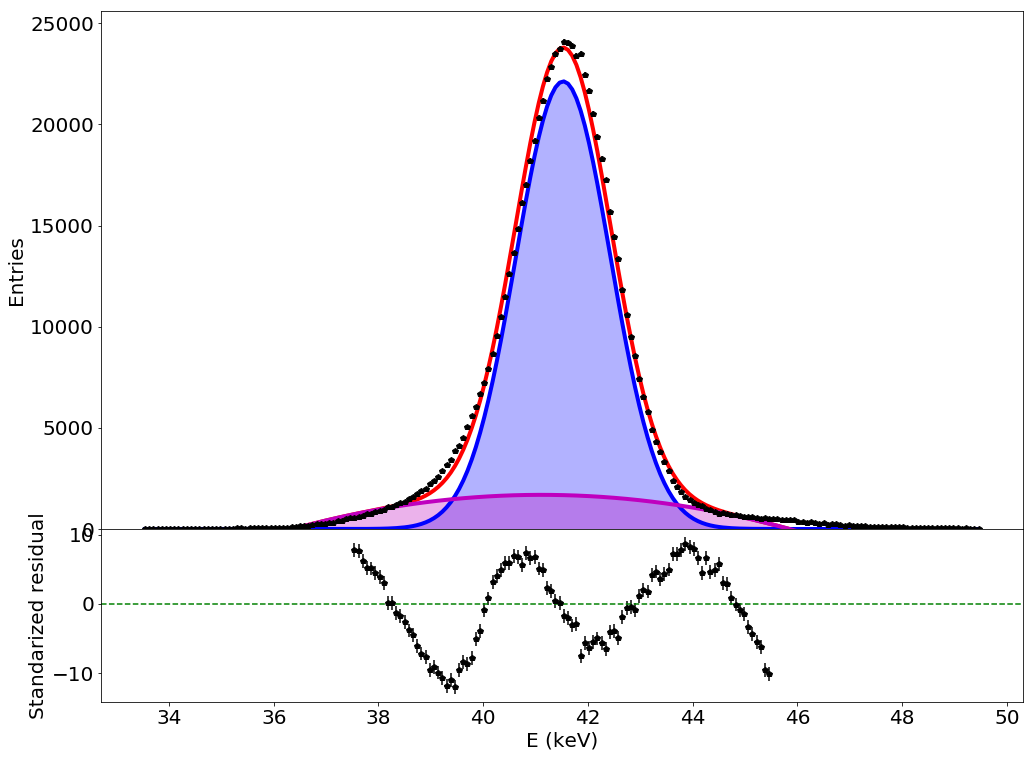

In [18]:
frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
frame_data.set_xticklabels([])
plt.ylabel("Entries")
plt.ylim(0)
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(data.residuals.x, data.residuals.y, 1, data.residuals.xu, fmt="p", c="k")
plt.plot    (lims, [0,0], "g--")
plt.xlim(*lims)
labels("E (keV)", "Standarized residual")
save("EnergySpectrumCool")

#### Best case

Resolution at 41.5 keV: 4.637 +- 0.012
Resolution at 2458 keV: 0.6025 +- 0.0016
Chi2                  : 1.49367852832


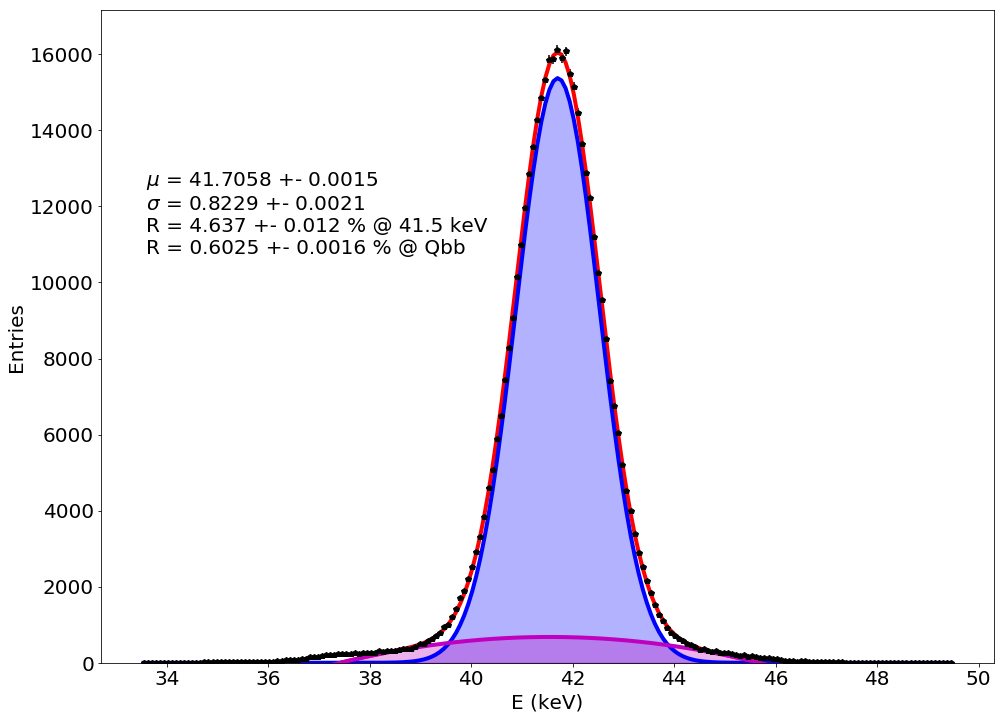

In [19]:
sel_r = coref.in_range(R, 0, R_fiducial)
bkg   = fitf.polynom
data  = measure_resolution(E[sel_r], bkg=bkg)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])

plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for R < {R_fiducial:.0f} mm")
save("EnergySpectrumFiducialR")

Resolution at 41.5 keV: 4.527 +- 0.025
Resolution at 2458 keV: 0.5882 +- 0.0033
Chi2                  : 5.1506888329


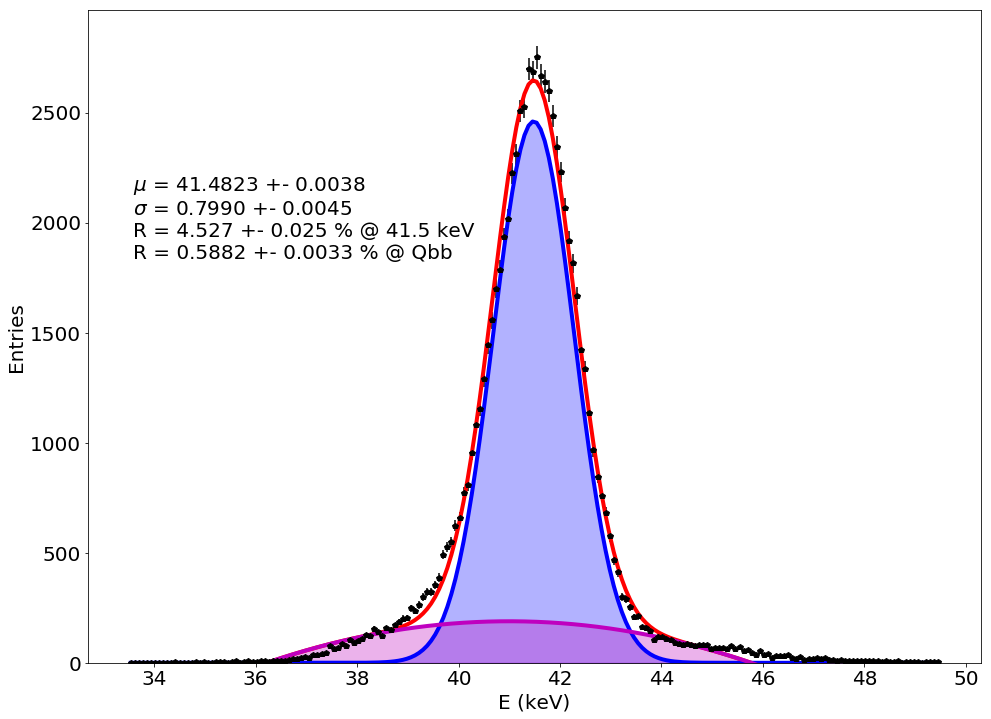

In [20]:
sel_z = coref.in_range(Z, 100, Z_fiducial)
bkg   = fitf.polynom
data  = measure_resolution(E[sel_z], bkg=bkg)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for Z < {Z_fiducial:.0f} µs")
save("EnergySpectrumFiducialZ")

Resolution at 41.5 keV: 3.977 +- 0.028
Resolution at 2458 keV: 0.5168 +- 0.0037
Chi2                  : 0.857939546144


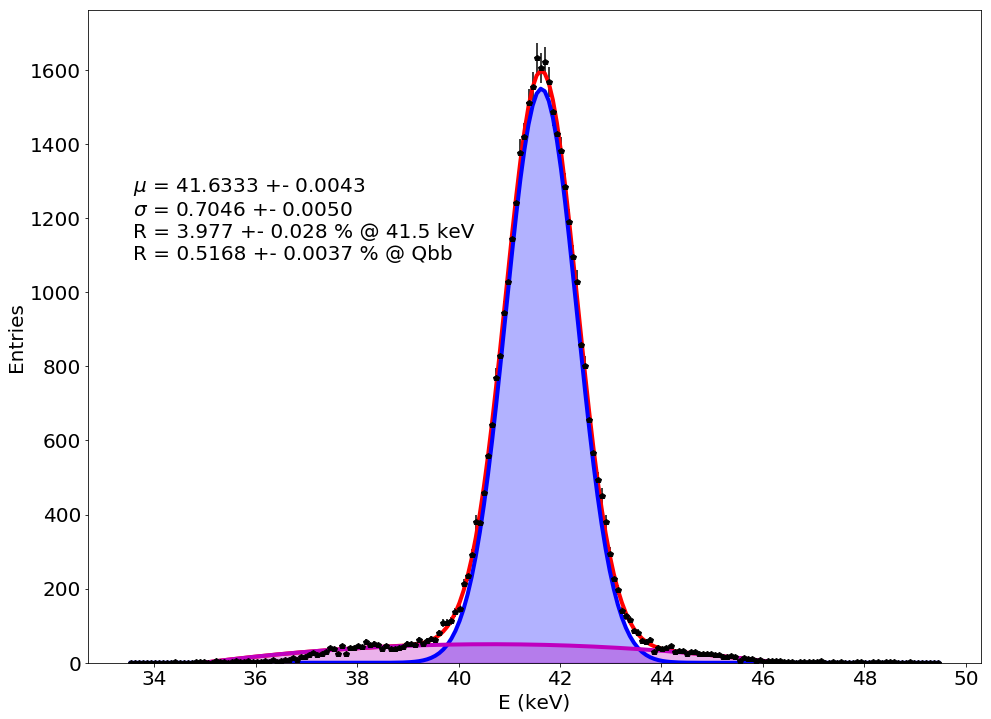

In [21]:
sel_r = coref.in_range(R, 0, R_fiducial)
sel_z = coref.in_range(Z, 100, Z_fiducial)
bkg   = fitf.polynom
data  = measure_resolution(E[sel_r & sel_z], bkg=bkg)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for R < {R_fiducial:.0f} mm, Z < {Z_fiducial:.0f} µs")
save("EnergySpectrumFiducialRZ")

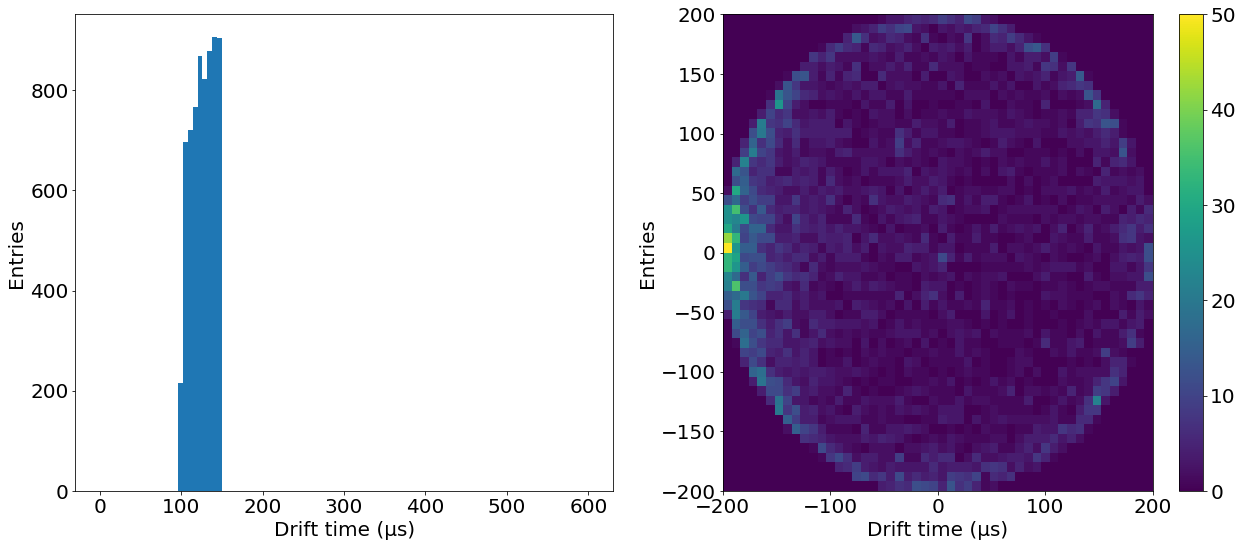

In [37]:
sel_r = True#coref.in_range(R,    0, R_fiducial)
sel_z = coref.in_range(Z,  100, Z_fiducial)
sel_E = coref.in_range(E, 39.5, 44)
sel   = sel_r & sel_z & ~sel_E

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
hist(Z[sel], Zbins, new_figure=False)
labels("Drift time (µs)", "Entries", "Z distribution bad events")

plt.subplot(1, 2, 2)
hist2d(X[sel], Y[sel], XYbins, new_figure=False)
plt.colorbar()
labels("Drift time (µs)", "Entries", "Z distribution bad events")

plt.tight_layout()

##### Energy resolution dependence

R in [0.0, 12.5) mm
| Resolution at 2458 keV: 1.85 +- 0.68
| Chi2                  : 0.817076413431
R in [12.5, 25.0) mm
| Resolution at 2458 keV: 0.505 +- 0.022
| Chi2                  : 0.641165430368
R in [25.0, 37.5) mm
| Resolution at 2458 keV: 0.495 +- 0.018
| Chi2                  : 0.679891031317
R in [37.5, 50.0) mm
| Resolution at 2458 keV: 0.513 +- 0.016
| Chi2                  : 0.909643926479
R in [50.0, 62.5) mm
| Resolution at 2458 keV: 0.498 +- 0.013
| Chi2                  : 0.901844118052
R in [62.5, 75.0) mm
| Resolution at 2458 keV: 0.487 +- 0.011
| Chi2                  : 1.14990347827
R in [75.0, 87.5) mm
| Resolution at 2458 keV: 0.501 +- 0.010
| Chi2                  : 1.16342236458
R in [87.5, 100.0) mm
| Resolution at 2458 keV: 0.5020 +- 0.0098
| Chi2                  : 1.01764141002
R in [100.0, 112.5) mm
| Resolution at 2458 keV: 0.5023 +- 0.0086
| Chi2                  : 1.04483702615
R in [112.5, 125.0) mm
| Resolution at 2458 keV: 0.5064 +- 0.0079
| Chi2 

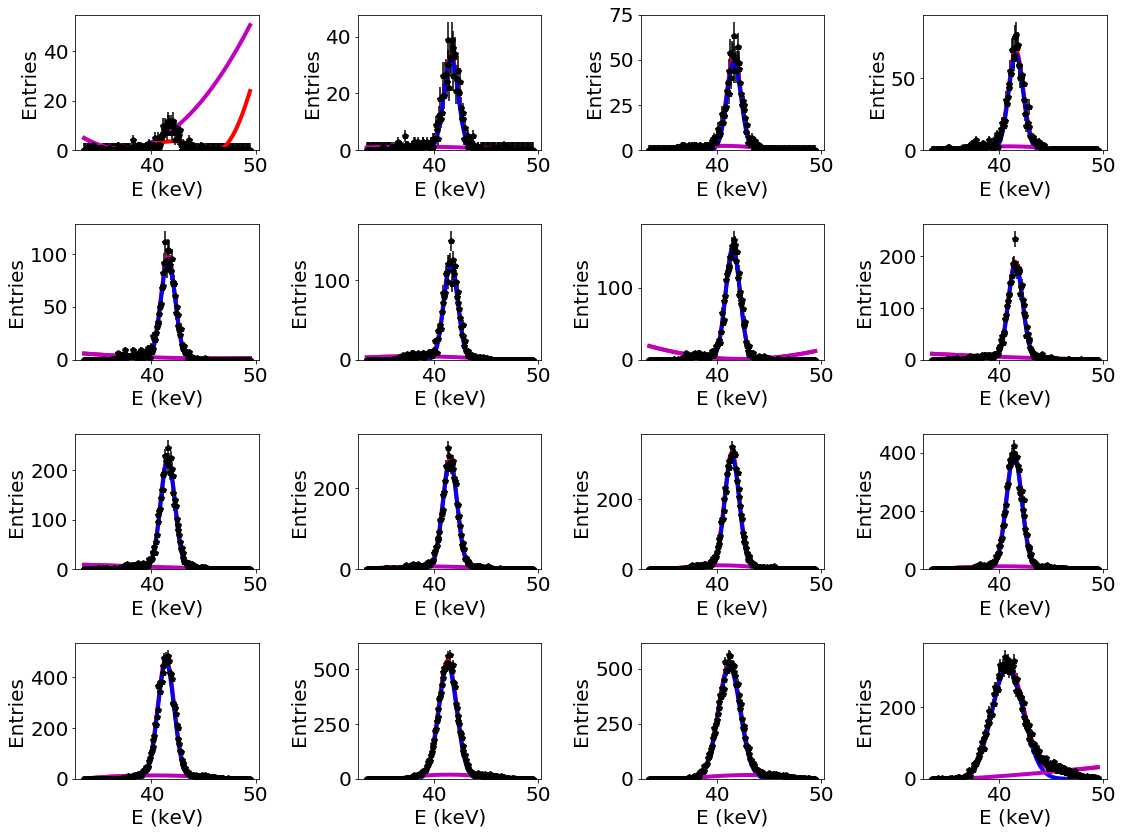

In [42]:
rbins = np.linspace(*Rrange, 17)
nbins = len(rbins) - 1
r     = shift_to_bin_centers(rbins)
dr    = 0.5 * np.diff       (rbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_z = coref.in_range(Z, 0, Z_fiducial)
for i in range(nbins):
    plt.subplot(4, 4, i+1)
    try:
        rmin, rmax = rbins[i:i+2]
        sel_r = coref.in_range(R, rmin, rmax)
        sel   = sel_r & sel_z
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E[sel], bkg=fitf.polynom)

        print(f"R in [{rmin:.1f}, {rmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"R $\in$ [{rmin:.1f}, {rmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionRslices")

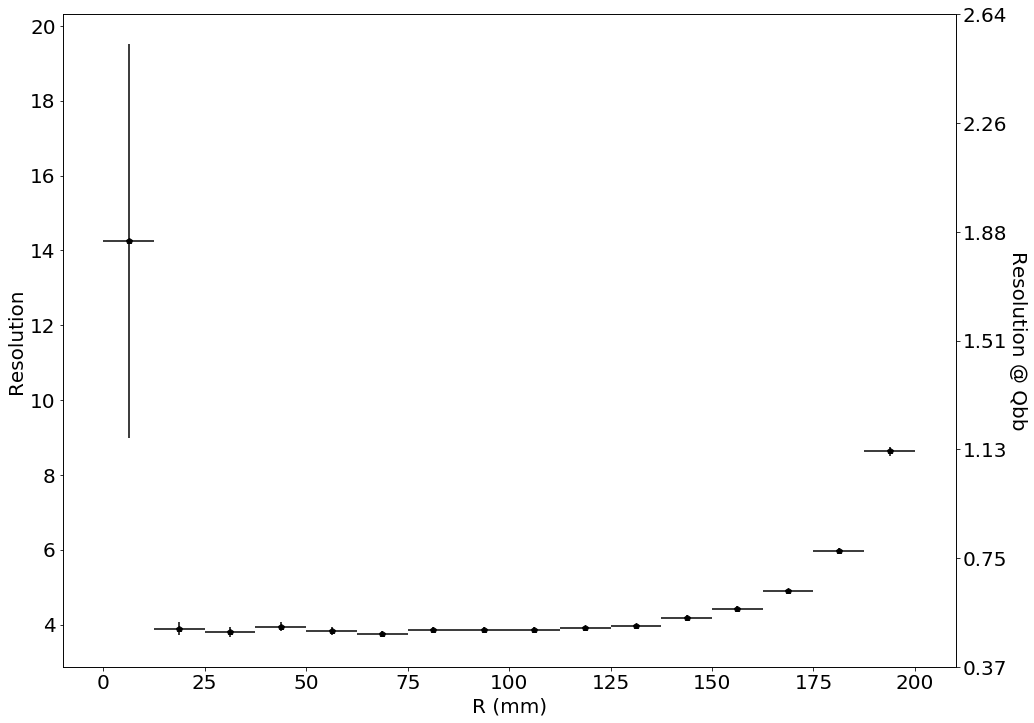

In [43]:
plt.errorbar(r[valid], Resolution[valid], Resolutionu[valid], dr[valid], "kp")
labels("R (mm)", "Resolution", "Resolution vs R")

new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionR")

Z in [50.0, 100.0) mm
| Resolution at 2458 keV: 0.5261 +- 0.0072
| Chi2                  : 1.62874952251
Z in [100.0, 150.0) mm
| Resolution at 2458 keV: 0.5105 +- 0.0035
| Chi2                  : 0.726561709503
Z in [150.0, 200.0) mm
| Resolution at 2458 keV: 0.5297 +- 0.0032
| Chi2                  : 0.950357093214
Z in [200.0, 250.0) mm
| Resolution at 2458 keV: 0.5512 +- 0.0035
| Chi2                  : 1.2802643212
Z in [250.0, 300.0) mm
| Resolution at 2458 keV: 0.5664 +- 0.0040
| Chi2                  : 1.4333758881
Z in [300.0, 350.0) mm
| Resolution at 2458 keV: 0.5878 +- 0.0045
| Chi2                  : 1.08577744482
Z in [350.0, 400.0) mm
| Resolution at 2458 keV: 0.6216 +- 0.0052
| Chi2                  : 0.990239589449
Z in [400.0, 450.0) mm
| Resolution at 2458 keV: 0.6483 +- 0.0061
| Chi2                  : 0.818811711027
Z in [450.0, 500.0) mm
| Resolution at 2458 keV: 0.6717 +- 0.0070
| Chi2                  : 1.15250678163
Z in [500.0, 550.0) mm
| Resolution at 2458 k

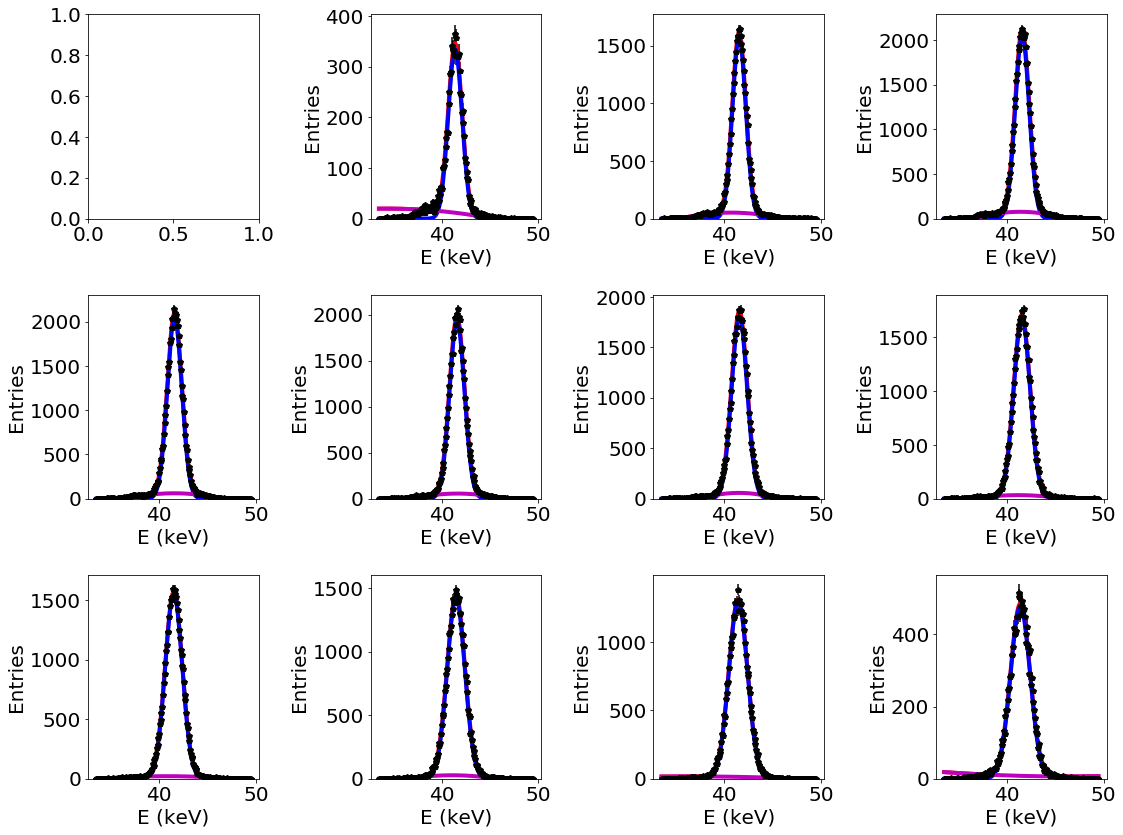

In [44]:
zbins = np.linspace(*Zrange, 13)
nbins = len(zbins) - 1
z     = shift_to_bin_centers(zbins)
dz    = 0.5 * np.diff       (zbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_r = coref.in_range(R, 0, R_fiducial)
for i in range(nbins):
    plt.subplot(3, 4, i+1)
    try:
        zmin, zmax = zbins[i:i+2]
        sel_z = coref.in_range(Z, zmin, zmax)
        sel   = sel_r & sel_z
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E[sel], bkg=fitf.polynom)

        print(f"Z in [{zmin:.1f}, {zmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"Z $\in$ [{zmin:.1f}, {zmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionZslices")

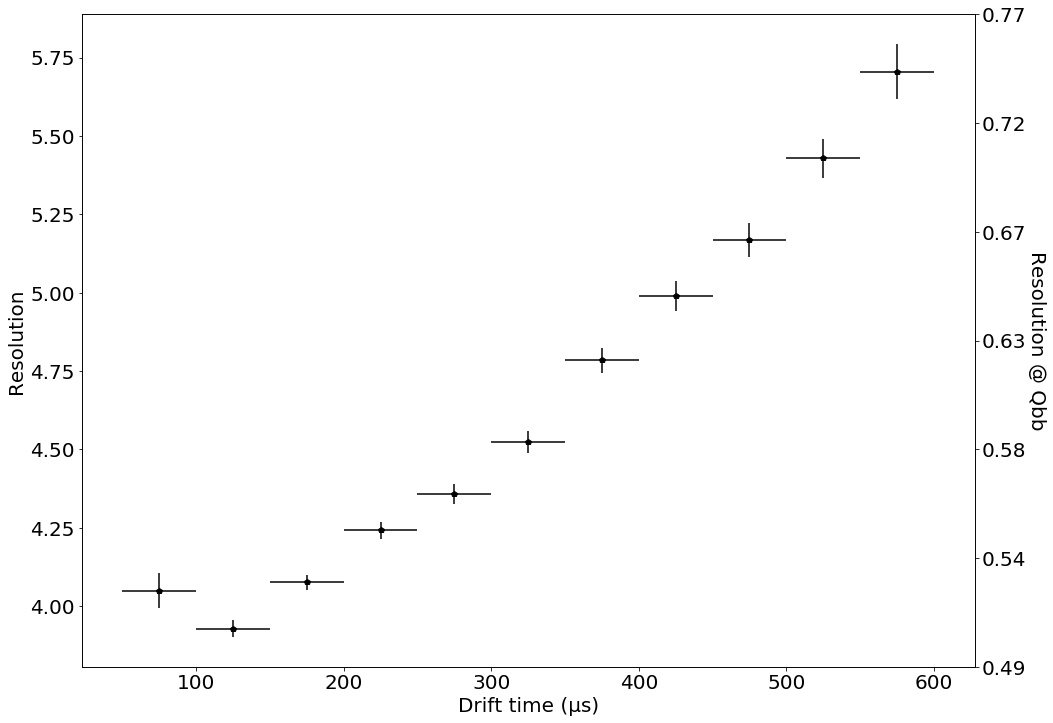

In [45]:
plt.errorbar(z[valid], Resolution[valid], Resolutionu[valid], dz[valid], "kp")
labels("Drift time (µs)", "Resolution", "Resolution vs Z")

new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionZ")

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:30: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))


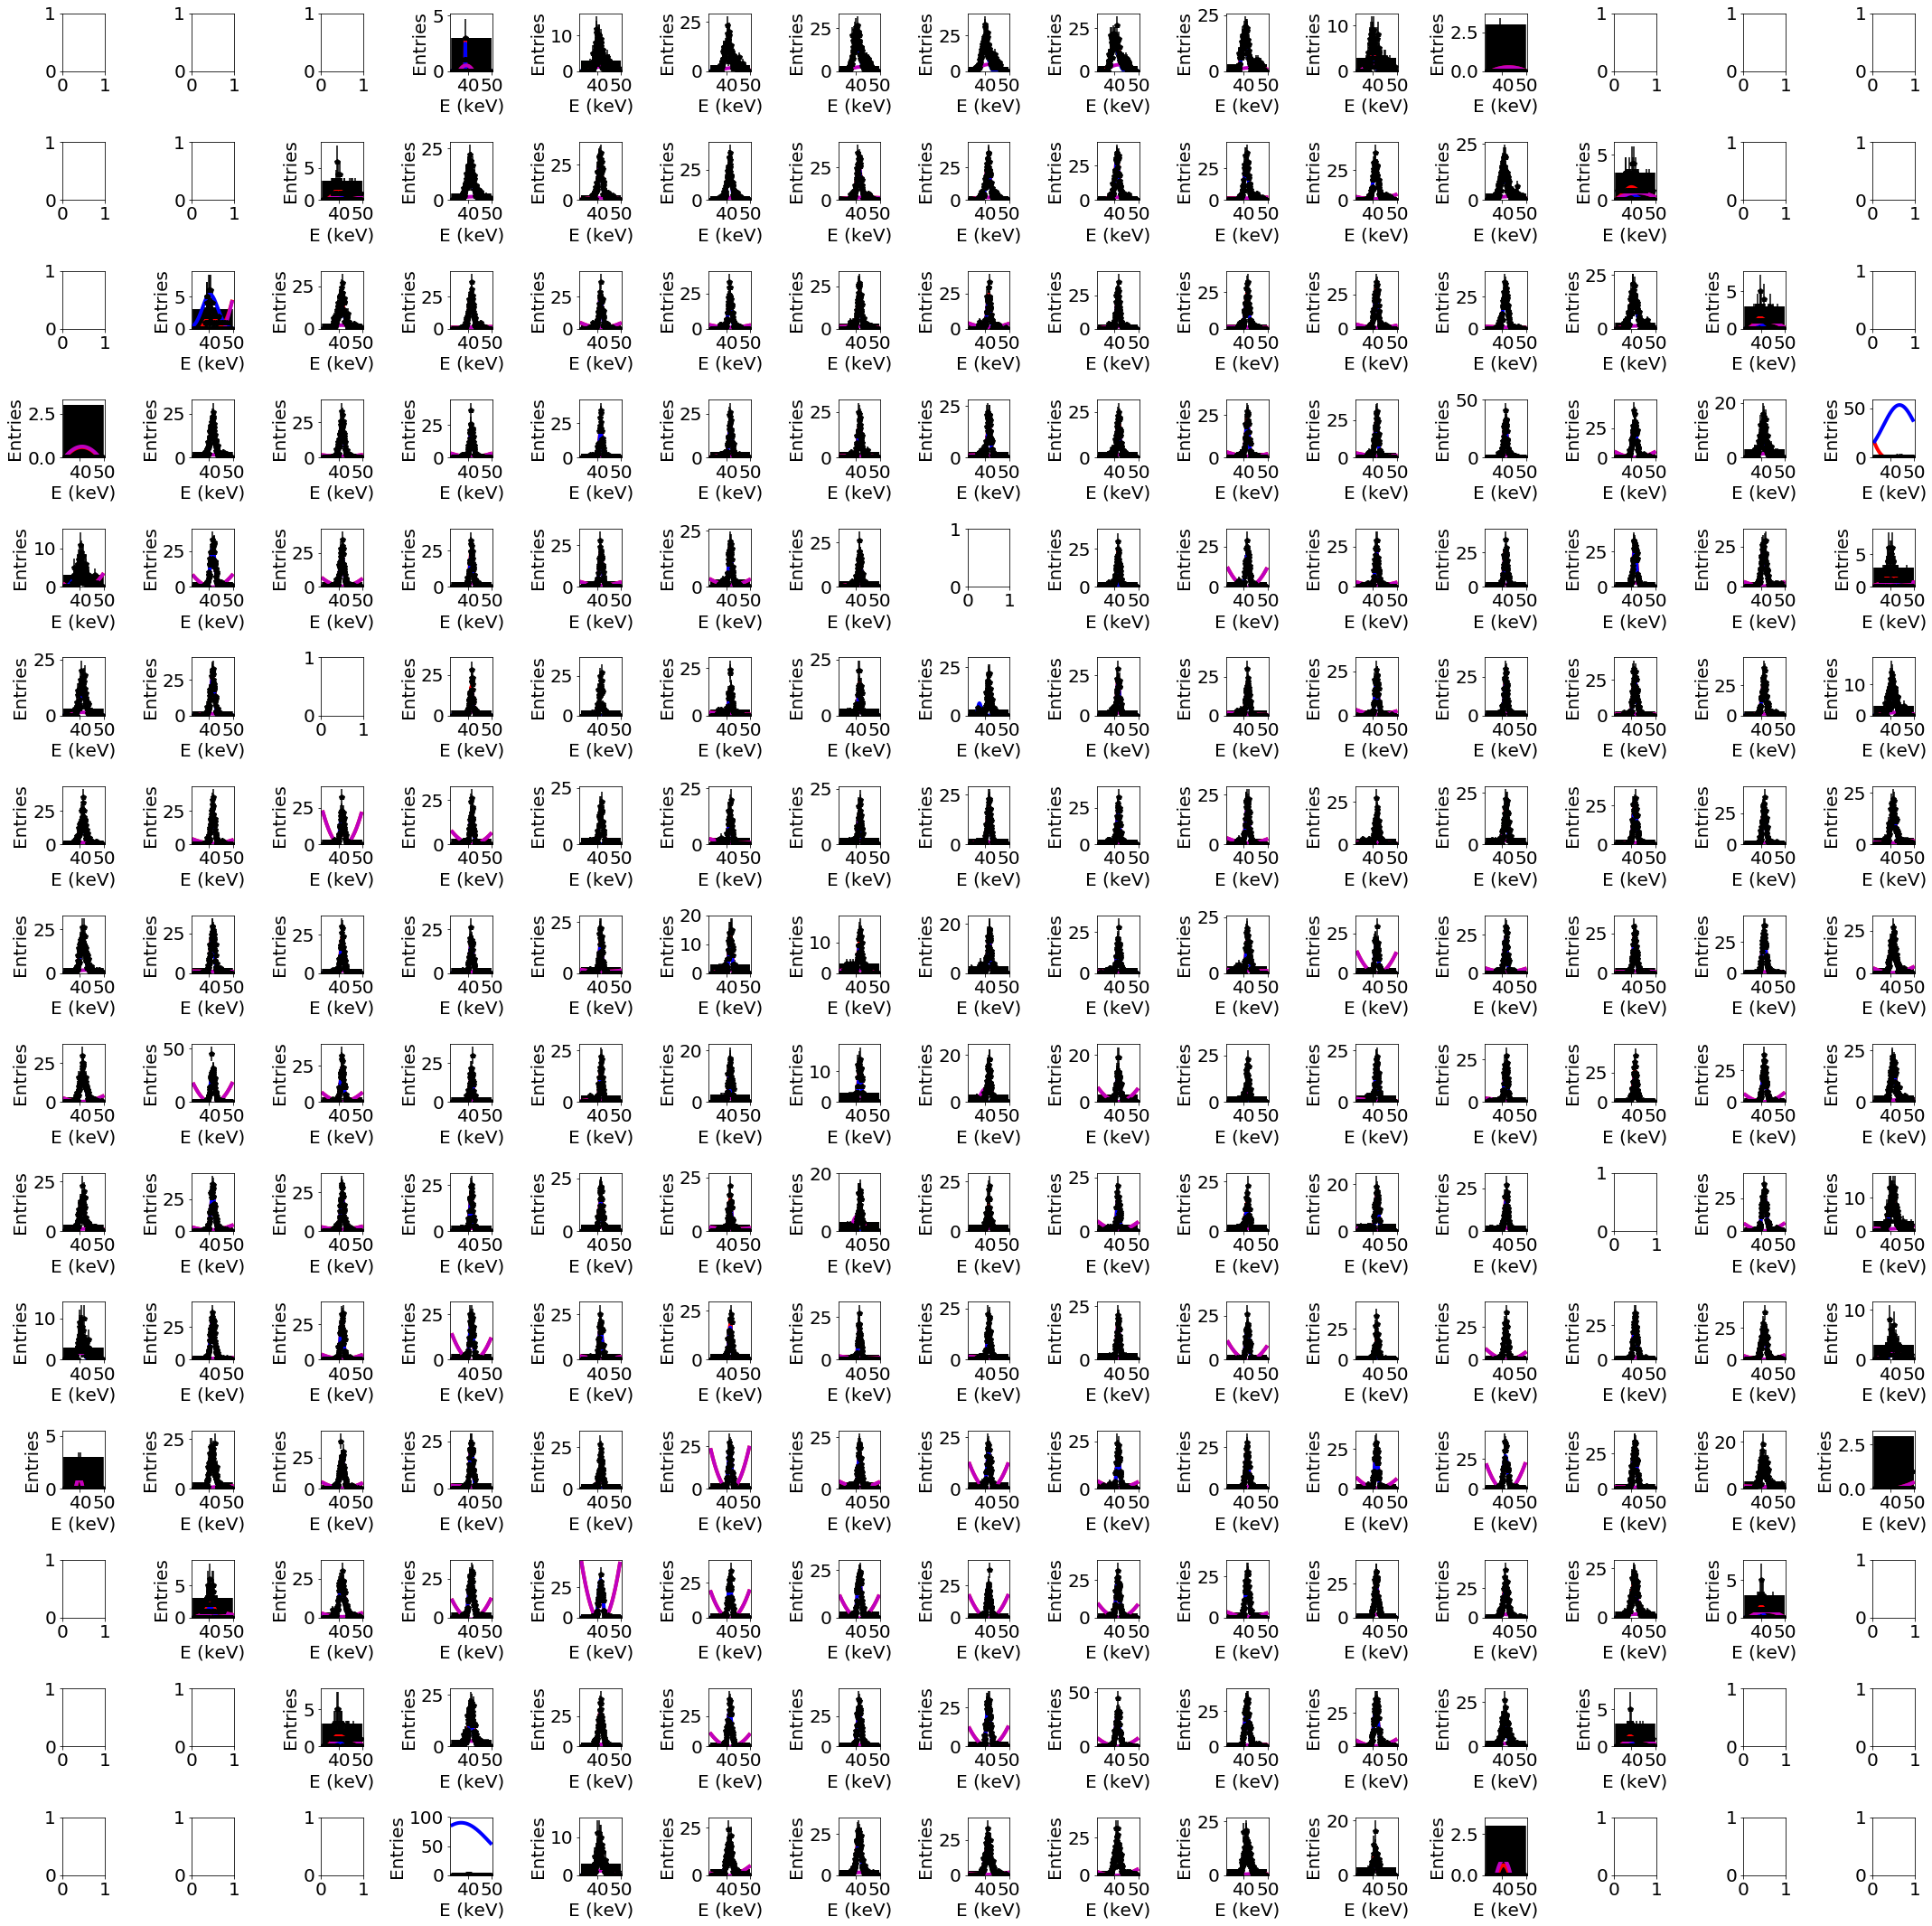

In [46]:
xybins = np.linspace(*XYrange, 16)
nbins  = len(xybins) - 1
xy     = shift_to_bin_centers(xybins)
dxy    = 0.5 * np.diff       (xybins)

valid         = np.zeros((nbins, nbins), dtype=bool     )
Chi2          = np.zeros((nbins, nbins), dtype=np.double)
Resolution    = np.zeros((nbins, nbins), dtype=np.double)
Resolutionu   = np.zeros((nbins, nbins), dtype=np.double)
ResolutionBB  = np.zeros((nbins, nbins), dtype=np.double)
ResolutionBBu = np.zeros((nbins, nbins), dtype=np.double)

plt.figure(figsize=(30, 30))

sel_z = coref.in_range(Z, 0, Z_fiducial)
for i in range(nbins):
    for j in range(nbins):
        plt.subplot(nbins, nbins, i * nbins + j + 1)

        xmin, xmax = xybins[i : i + 2]
        ymin, ymax = xybins[j : j + 2]
        sel_x = coref.in_range(X, xmin, xmax)
        sel_y = coref.in_range(Y, ymin, ymax)

        try:
            data  = measure_resolution(E[sel_x & sel_y & sel_z], bkg=fitf.polynom)

            x = data.xy.x
            plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
            plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
            plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
            plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

            plt.ylim(0)
            labels("E (keV)", "Entries", f"Z $\in$ [{zmin:.1f}, {zmax:.1f}) mm")

            Resolution  [i, j], Resolutionu  [i, j] = data.R[0]
            ResolutionBB[i, j], ResolutionBBu[i, j] = data.R[1]
            Chi2        [i, j]                      = data.f.chi2
            valid       [i, j]                      = True
        except:
            pass

plt.tight_layout()
save("ResolutionXYbins")

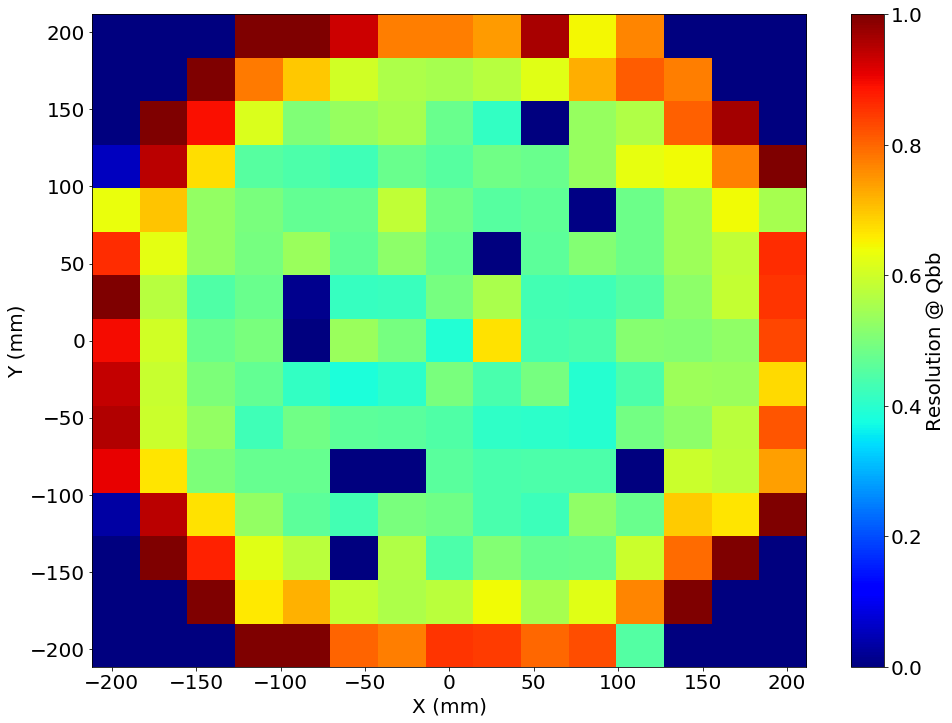

In [47]:
*_, cb = display_matrix(xy, xy, ResolutionBB, vmin = 0, vmax = 1,
                        cmap = default_cmap)
cb.set_label("Resolution @ Qbb")
labels("X (mm)", "Y (mm)", "Resolution vs XY")
save("ResolutionXY")